In [1]:
import torch  
import pandas as pd  
import numpy as np  
import torch.nn as nn  
from sklearn.preprocessing import MinMaxScaler  
from sklearn.metrics import r2_score 
from statsmodels.tsa.seasonal import STL  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
print(device)

cuda


In [2]:
import pandas as pd  
from sklearn.preprocessing import MinMaxScaler  
from statsmodels.tsa.seasonal import STL  
  
# Sample and Decomposite Data  
df = pd.read_csv('resampled_cpu_usage_per_machine.csv')    
df['start_time'] = pd.to_datetime(df['start_time'])    
df.set_index('start_time', inplace=True)    
  
# Select machines    
machines = df['machine_id'].unique()[:20]  
  
# Scale data to (0, 1) for LSTM    
scaler = MinMaxScaler(feature_range=(0, 1))  

# Initialize a list to store each machine's df  
dfs = []  
  
# Loop over each machine  
for machine in machines:  
    df_machine = df[df['machine_id'] == machine]  
    df_machine = df_machine[['machine_id', 'maximum_cpu_usage']]  
    df_machine = df_machine.resample('H').mean()  
    df_machine['maximum_cpu_usage'] = scaler.fit_transform(df_machine['maximum_cpu_usage'].values.reshape(-1,1))    
 
    stl = STL(df_machine['maximum_cpu_usage'], seasonal=13)    
    result = stl.fit()    
    df_machine['trend'] = result.trend   
    df_machine['detrended'] = df_machine['maximum_cpu_usage'] - df_machine['trend']    

    dfs.append(df_machine) 

df = pd.concat(dfs)
data = {machine: df[df['machine_id'] == machine]['maximum_cpu_usage'].values for machine in machines} 
print(df)
# Convert DataFrame to numpy array    

                     machine_id  maximum_cpu_usage     trend  detrended
start_time                                                             
2011-05-01 00:00:00    381129.0           0.543291  0.461931   0.081360
2011-05-01 01:00:00    381129.0           0.525584  0.454948   0.070636
2011-05-01 02:00:00    381129.0           0.584738  0.448021   0.136717
2011-05-01 03:00:00    381129.0           0.530150  0.441155   0.088996
2011-05-01 04:00:00    381129.0           0.258080  0.434347  -0.176267
...                         ...                ...       ...        ...
2011-05-29 20:00:00  38649757.0           0.446844  0.452325  -0.005480
2011-05-29 21:00:00  38649757.0           0.433372  0.455272  -0.021900
2011-05-29 22:00:00  38649757.0           0.421125  0.458200  -0.037074
2011-05-29 23:00:00  38649757.0           0.572367  0.461094   0.111273
2011-05-30 00:00:00  38649757.0           0.101263  0.463944  -0.362681

[13940 rows x 4 columns]


In [3]:
import torch  
  
# Initialize lists to store train and test data  
train_inout_seq = {}  
test_inout_seq = {}  

train_data_loader = {}  
test_data_loader = {} 

train_data = {}  
test_data = {}  

# Create sequences    
def create_sequences(trend_data, detrended_data, seq_length_in, seq_length_out):      
    inout_seq = []      
    L = len(trend_data)      
    for i in range(L-seq_length_in-seq_length_out):      
        train_seq_trend = torch.FloatTensor(trend_data[i:i+seq_length_in])    
        train_seq_detrended = torch.FloatTensor(detrended_data[i:i+seq_length_in])    
        train_label = torch.FloatTensor(trend_data[i+seq_length_in:i+seq_length_in+seq_length_out] + detrended_data[i+seq_length_in:i+seq_length_in+seq_length_out])     
        inout_seq.append(((train_seq_trend, train_seq_detrended), train_label))      
    return inout_seq   
  
# Loop over each machine  
for machine in machines:  
    df_machine = df[df['machine_id'] == machine] 
  
    # Split data into train and test sets    
    seq_length_in = 48  
    seq_length_out = 6  
    batch_size = 512  
    train_size = int(len(df_machine) * 0.70)    
    train_data[machine], test_data[machine] = data[machine][:train_size], data[machine][train_size:]  
    train_trend_data, test_trend_data = df_machine['trend'].values[:train_size], df_machine['trend'].values[train_size:]    
    train_detrended_data, test_detrended_data = df_machine['detrended'].values[:train_size], df_machine['detrended'].values[train_size:]    
  
    # Create sequences    
    train_inout_seq[machine] = create_sequences(train_trend_data, train_detrended_data, seq_length_in, seq_length_out)    
    test_inout_seq[machine] = create_sequences(test_trend_data, test_detrended_data, seq_length_in, seq_length_out)  
  
    # Create DataLoaders and store them in dictionaries  
    train_data_loader[machine] = torch.utils.data.DataLoader(train_inout_seq[machine], batch_size=batch_size, shuffle=True)    
    test_data_loader[machine] = torch.utils.data.DataLoader(test_inout_seq[machine], batch_size=batch_size, shuffle=True)   
  
# # Create DataLoader for mini-batches, take 64 each time  
# 
# train_data_loader = torch.utils.data.DataLoader(train_inout_seq, batch_size=batch_size, shuffle=True)    
# test_data_loader = torch.utils.data.DataLoader(test_inout_seq, batch_size=batch_size, shuffle=True)    


In [4]:
class Attention(nn.Module):  
    def __init__(self, hidden_size):  
        super(Attention, self).__init__()  
        self.hidden_size = hidden_size  
        self.attention_layer = nn.Linear(hidden_size * 2, hidden_size)  
        self.softmax = nn.Softmax(dim=1)  
  
    def forward(self, trend, detrended):  
        concat = torch.cat((trend, detrended), dim=2)  # concatenate along the third dimension  
        attn_weights = self.softmax(self.attention_layer(concat))  # compute attention weights  
        attn_output = attn_weights * trend + (1 - attn_weights) * detrended  # apply attention weights  
        return attn_output  


class STL_LSTM(nn.Module):  
    def __init__(self, input_size, hidden_size, num_layers, output_size):  
        super(STL_LSTM, self).__init__()  
        self.hidden_size = hidden_size  
        self.num_layers = num_layers  
  
        self.lstm_trend = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  
        self.lstm_detrended = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  
        self.attention = Attention(hidden_size)  
        self.fc = nn.Linear(hidden_size, output_size)  
  
    def forward(self, trend, detrended):  
        h_0_trend = torch.zeros(self.num_layers, trend.size(0), self.hidden_size).to(trend.device)  
        c_0_trend = torch.zeros(self.num_layers, trend.size(0), self.hidden_size).to(trend.device)  
        out_trend, _ = self.lstm_trend(trend, (h_0_trend, c_0_trend))  
      
        h_0_detrended = torch.zeros(self.num_layers, detrended.size(0), self.hidden_size).to(detrended.device)  
        c_0_detrended = torch.zeros(self.num_layers, detrended.size(0), self.hidden_size).to(detrended.device)  
        out_detrended, _ = self.lstm_detrended(detrended, (h_0_detrended, c_0_detrended))  
      
        attn_output = self.attention(out_trend, out_detrended)  
      
        out = self.fc(attn_output[:, -1, :])  
      
        return out  


  
# Set up LSTM model parameters
num_epochs = 2000
learning_rate = 0.01  
input_size = 1  
hidden_size = 100
num_layers = 1
output_size = seq_length_out
  
lstm = STL_LSTM(input_size, hidden_size, num_layers, output_size).to(device)
  
# Set loss function and optimizer  
criterion = torch.nn.MSELoss()    # mean-squared error for regression  
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)   
  
# Train model  
lstm.train()
for epoch in range(num_epochs):  
    sample_num = 0
    squared_error_sum = 0
    
    for machine_id, data_loader in train_data_loader.items(): 
        for i, ((seq_trend, seq_detrended), labels) in enumerate(data_loader):   
            seq_trend = torch.FloatTensor(seq_trend).view(-1, seq_length_in, input_size).to(device)  
            seq_detrended = torch.FloatTensor(seq_detrended).view(-1, seq_length_in, input_size).to(device)  
            labels = torch.FloatTensor(labels).view(-1, seq_length_out).to(device)  
          
            optimizer.zero_grad()    
            y_pred = lstm(seq_trend, seq_detrended)    
          
            single_loss = criterion(y_pred, labels)    
            single_loss.backward()    
            optimizer.step()    
  
    if (epoch+1)%100 == 0:  
        train_rmse = np.sqrt(single_loss.item())
        train_mse = np.mean(single_loss.item())
        print('epoch: ', epoch+1, 'train RMSE: ', train_rmse, 'train MSE: ', train_mse, 'loss: ', single_loss.item())     

torch.save(lstm.state_dict(), './predict_service/models/10.5_LSTM_seq2seq_STL_Attention_multiple_machine_miniSGD.pth') 
# Test model
lstm.eval()
predictions = []
test_rmse = 0
test_mse = 0
ttl = 0
predictions = []  
actuals = [] 
with torch.no_grad():  
    for machine_id, seqs in test_inout_seq.items():  
        for (seq_trend, seq_detrended), labels in seqs:   
            seq_trend = torch.FloatTensor(seq_trend).view(-1, seq_length_in, input_size).to(device)  
            seq_detrended = torch.FloatTensor(seq_detrended).view(-1, seq_length_in, input_size).to(device)  
            labels = torch.FloatTensor(labels).view(-1, seq_length_out).to(device)  
            y_test_pred = lstm(seq_trend, seq_detrended)
              
            # Ensure labels and y_test_pred have the same size  
            if y_test_pred.shape != labels.shape:  
                print("Shape mismatch: y_test_pred has shape {} but labels have shape {}".format(y_test_pred.shape, labels.shape))  
                continue  
    
            predictions.append(y_test_pred.cpu().detach().numpy())  
            actuals.append(labels.cpu().detach().numpy())  
      
            test_loss = criterion(y_test_pred, labels) 
            test_rmse += np.sqrt(test_loss.item())
            test_mse += np.mean(test_loss.item())
            ttl += 1
        
# Flatten the lists of predictions and actuals into 1D arrays  
predictions = np.concatenate(predictions).ravel()  
actuals = np.concatenate(actuals).ravel()  
r2 = r2_score(actuals, predictions)  

print('test RMSE: ', test_rmse/ttl, 'test MSE: ', test_mse/ttl, 'r2-score: ', r2)   

epoch:  100 train RMSE:  0.11701986720977985 train MSE:  0.01369364932179451 loss:  0.01369364932179451
epoch:  200 train RMSE:  0.09916609883980641 train MSE:  0.009833915159106255 loss:  0.009833915159106255
epoch:  300 train RMSE:  0.06424788830307485 train MSE:  0.004127791151404381 loss:  0.004127791151404381
epoch:  400 train RMSE:  0.045804488127630924 train MSE:  0.002098051132634282 loss:  0.002098051132634282
epoch:  500 train RMSE:  0.03823181483150989 train MSE:  0.0014616716653108597 loss:  0.0014616716653108597
epoch:  600 train RMSE:  0.0394559491558357 train MSE:  0.0015567719237878919 loss:  0.0015567719237878919
epoch:  700 train RMSE:  0.029615750043276885 train MSE:  0.0008770926506258547 loss:  0.0008770926506258547
epoch:  800 train RMSE:  0.03213548252377442 train MSE:  0.001032689237035811 loss:  0.001032689237035811
epoch:  900 train RMSE:  0.04630325739540964 train MSE:  0.002143991645425558 loss:  0.002143991645425558
epoch:  1000 train RMSE:  0.0341140713286

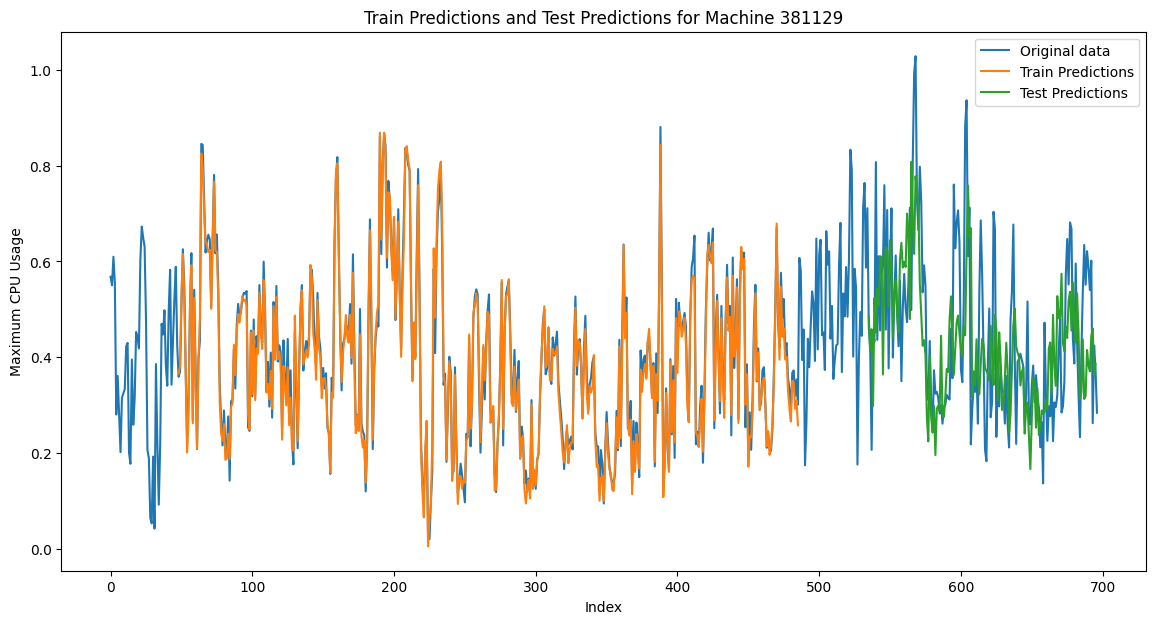

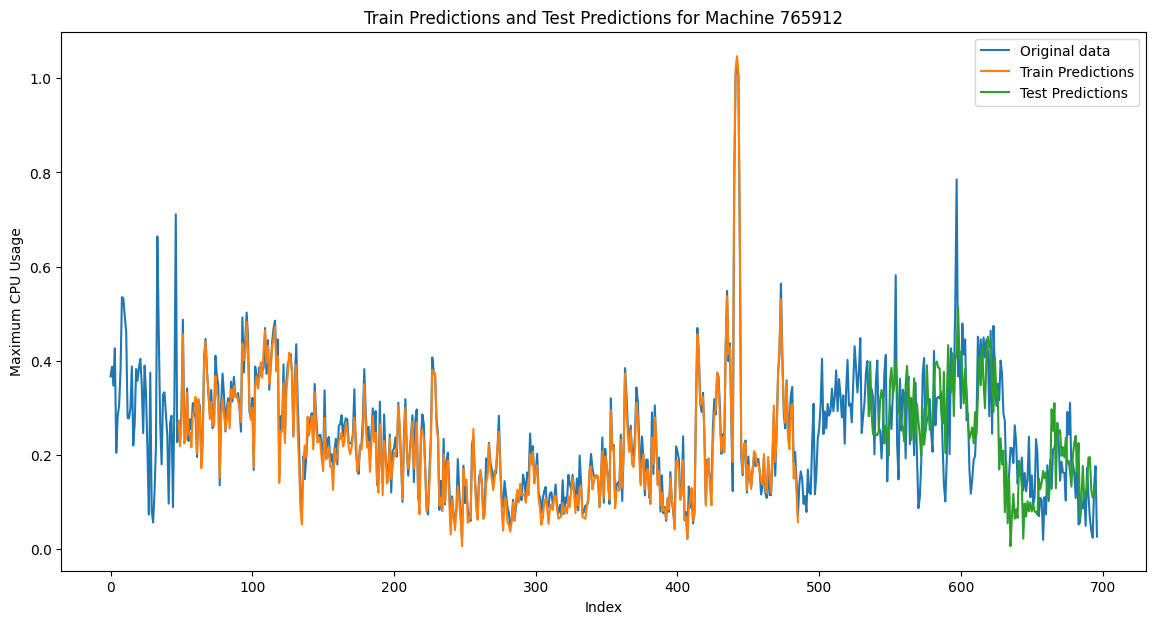

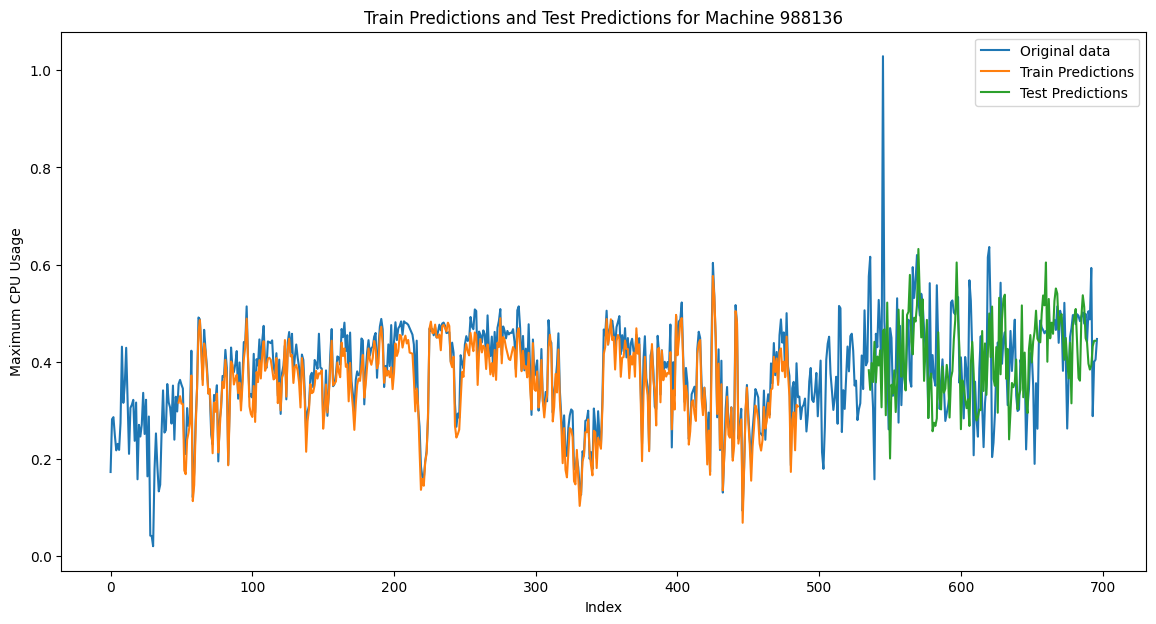

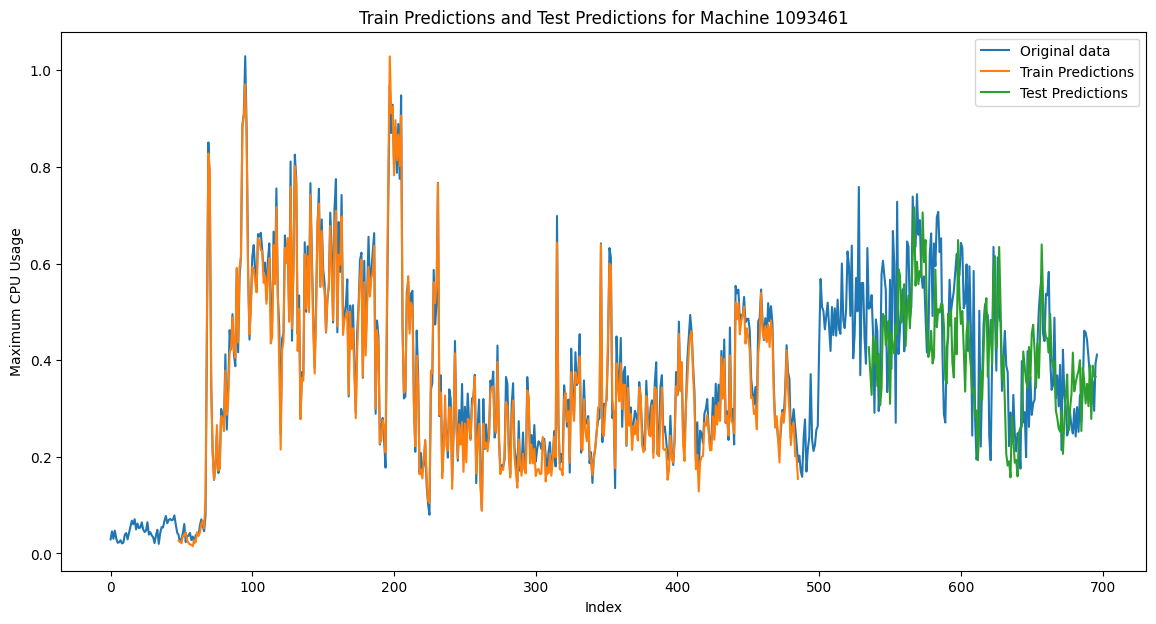

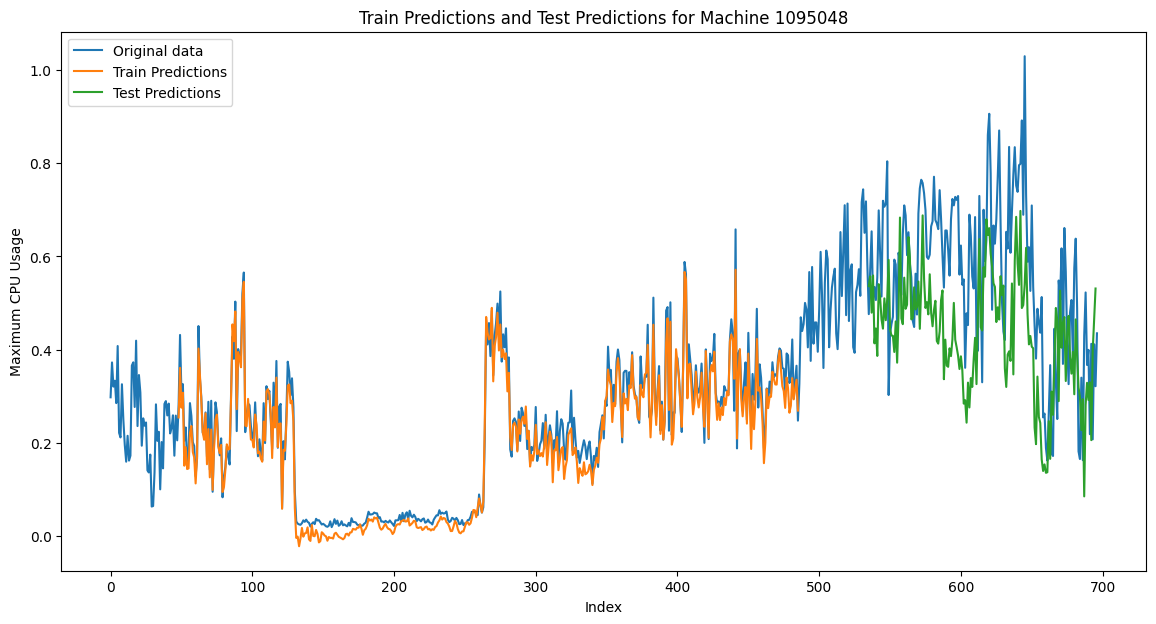

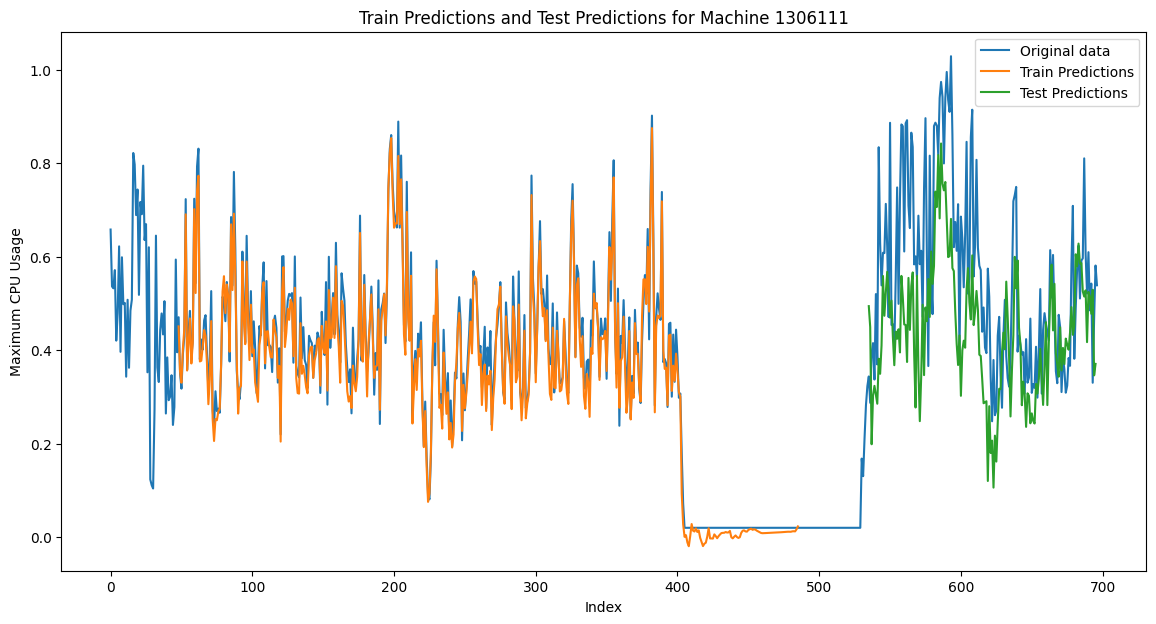

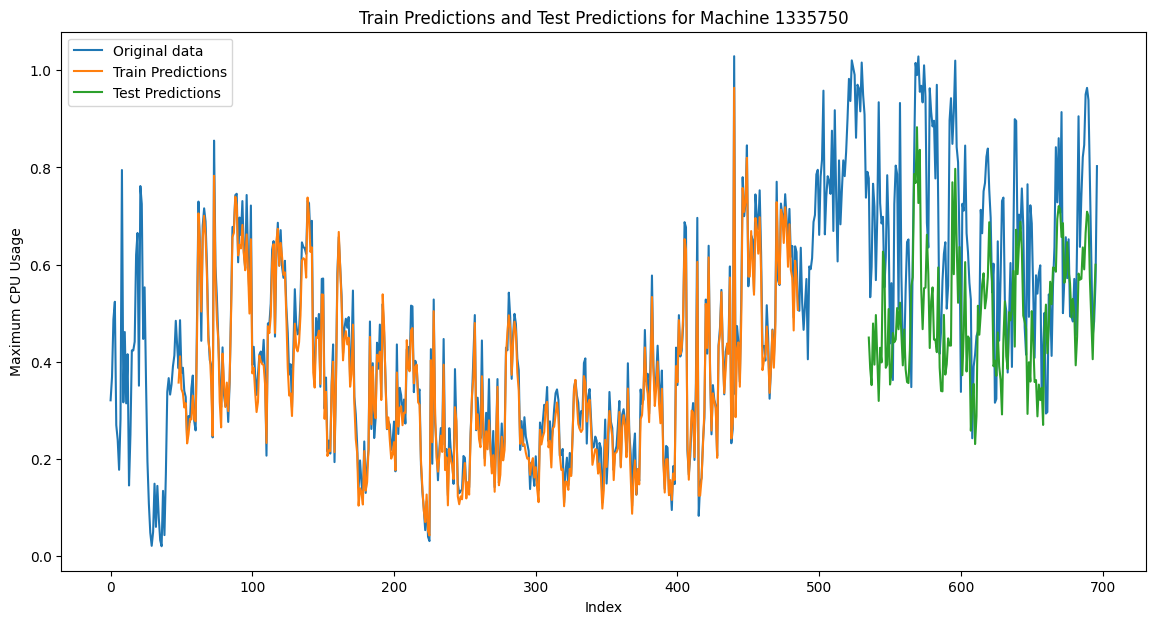

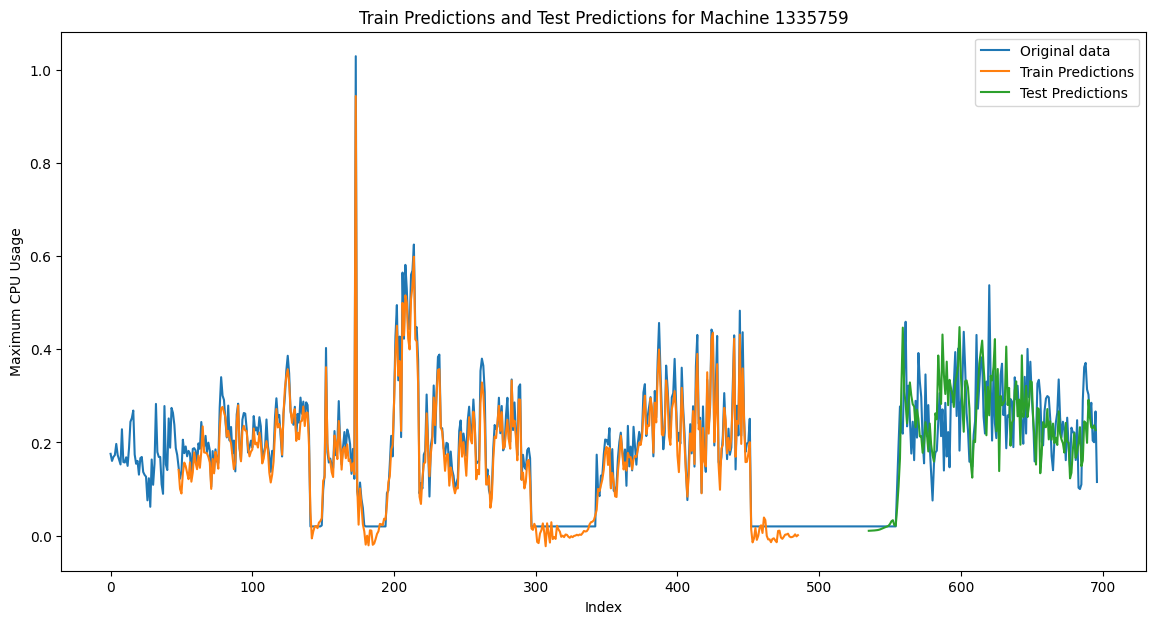

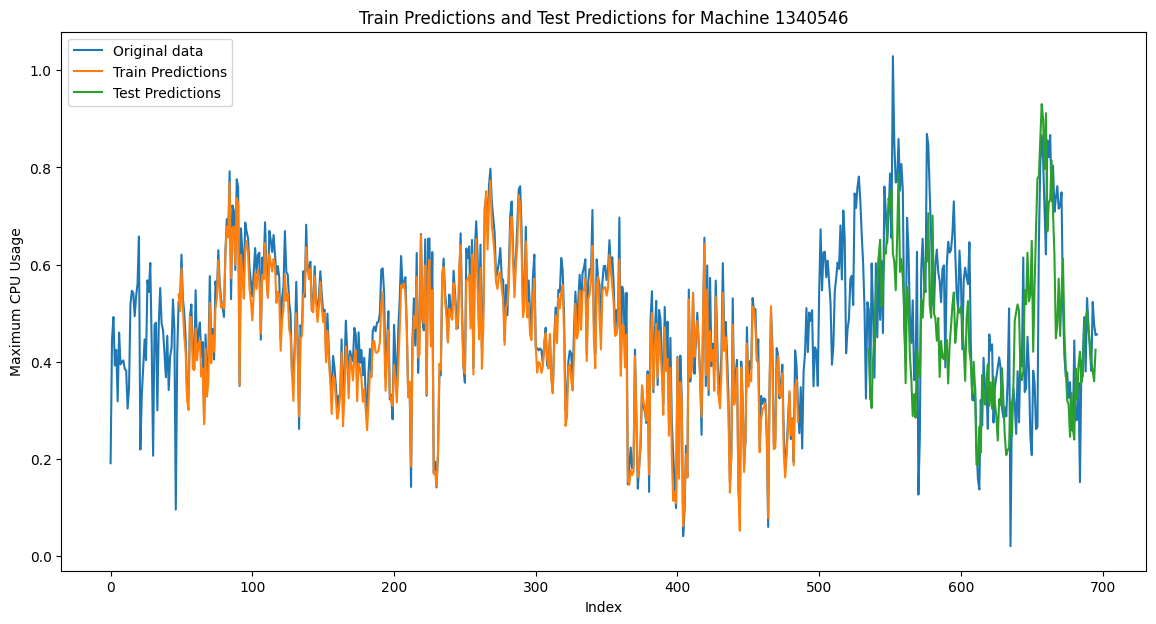

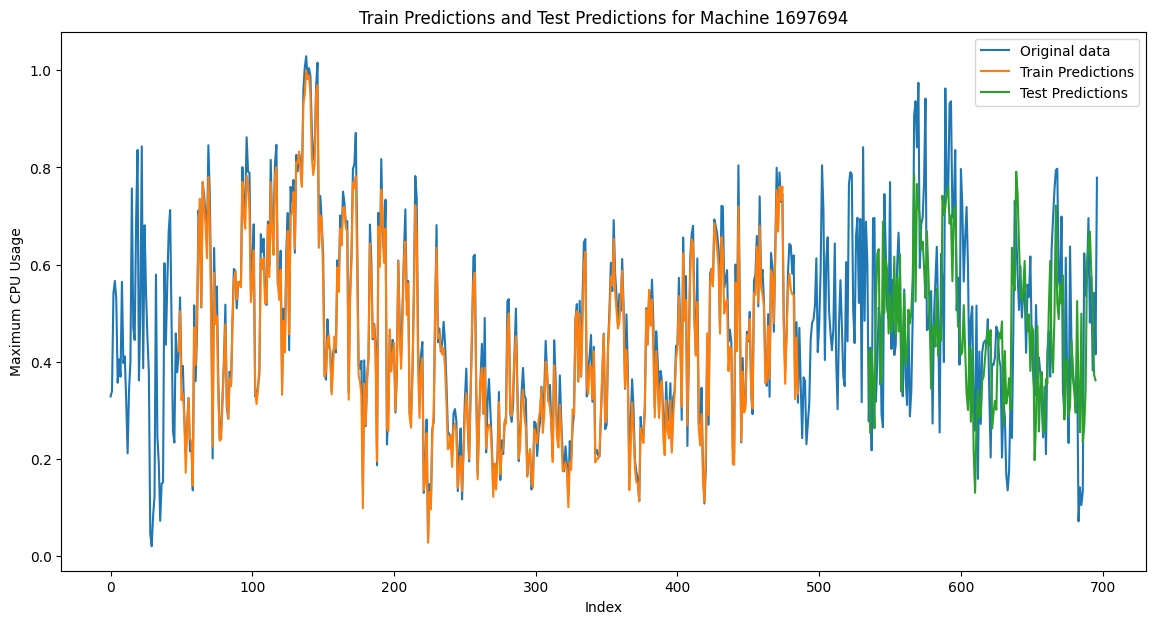

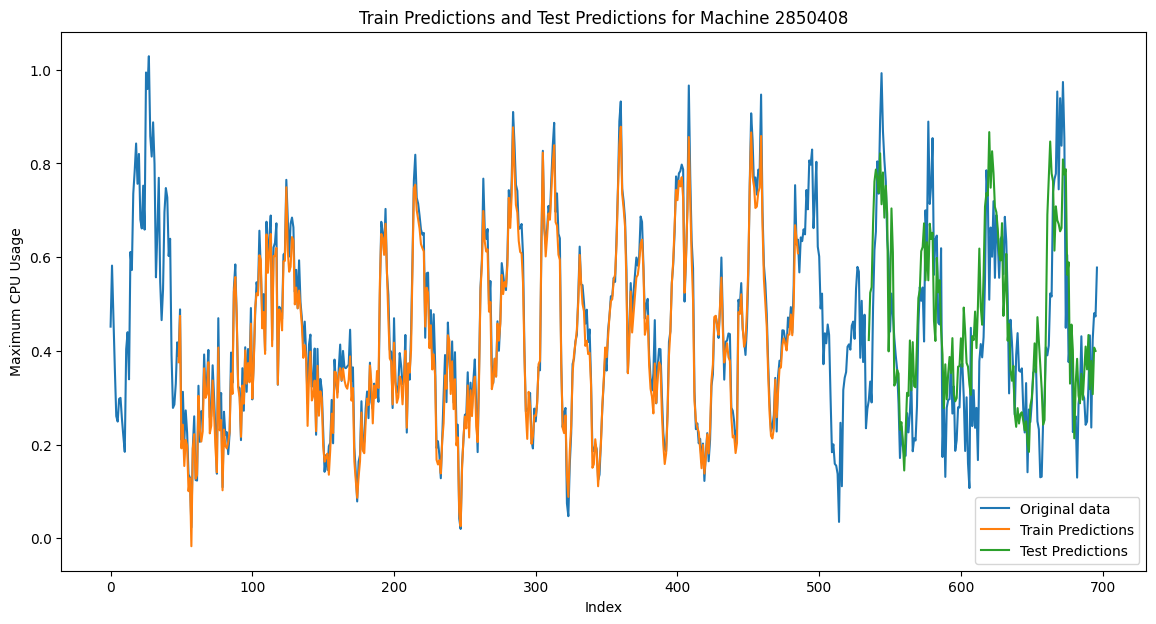

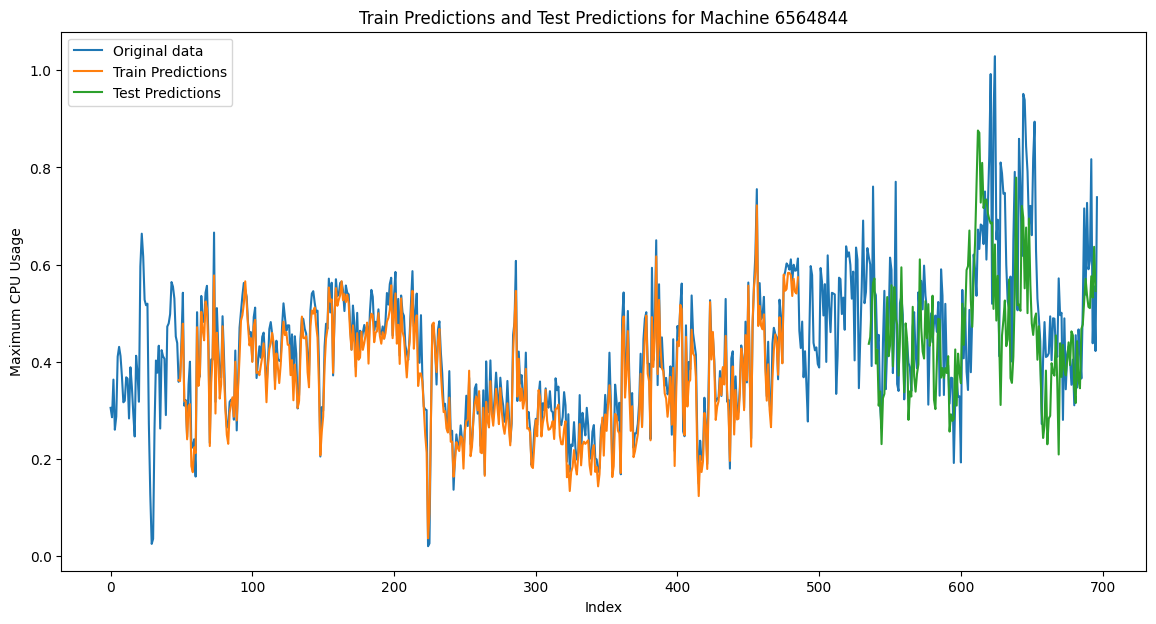

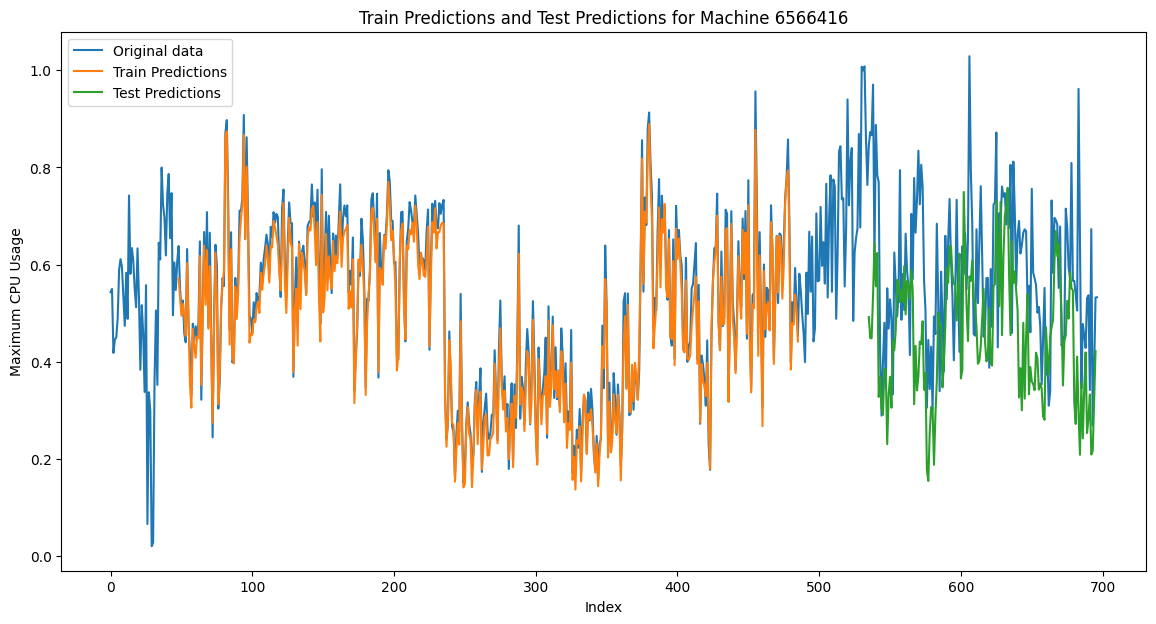

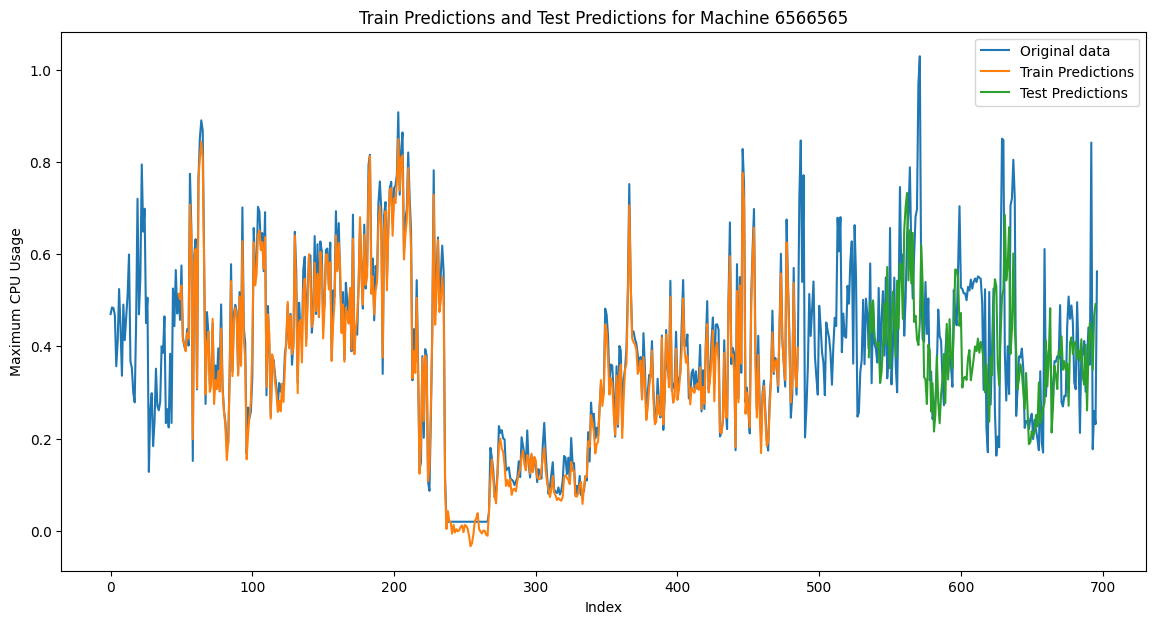

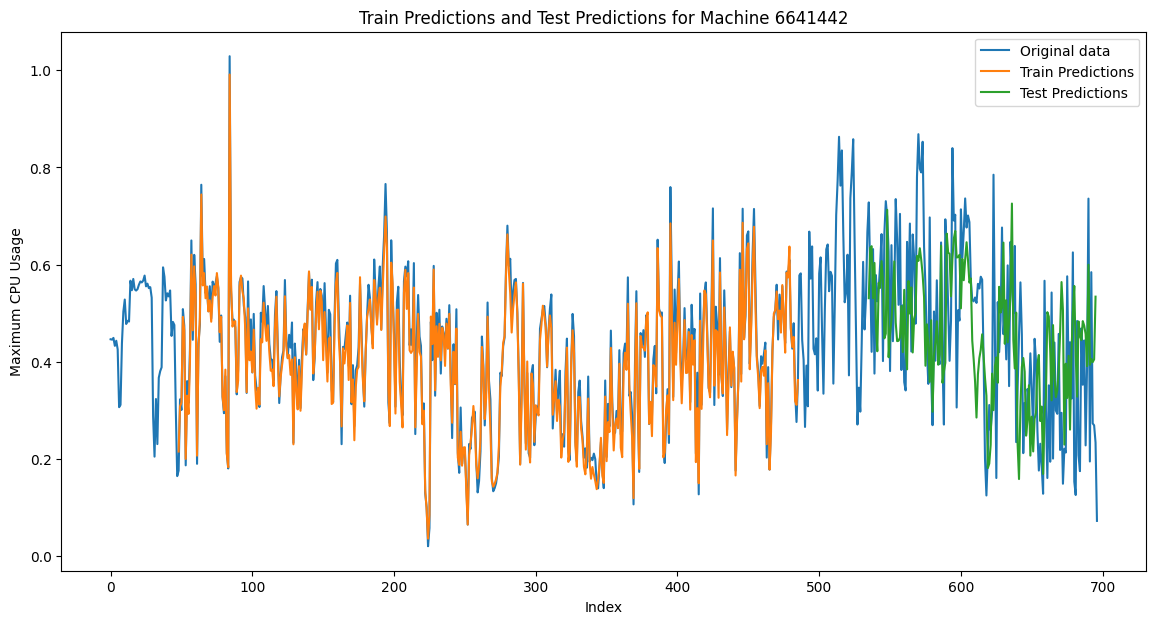

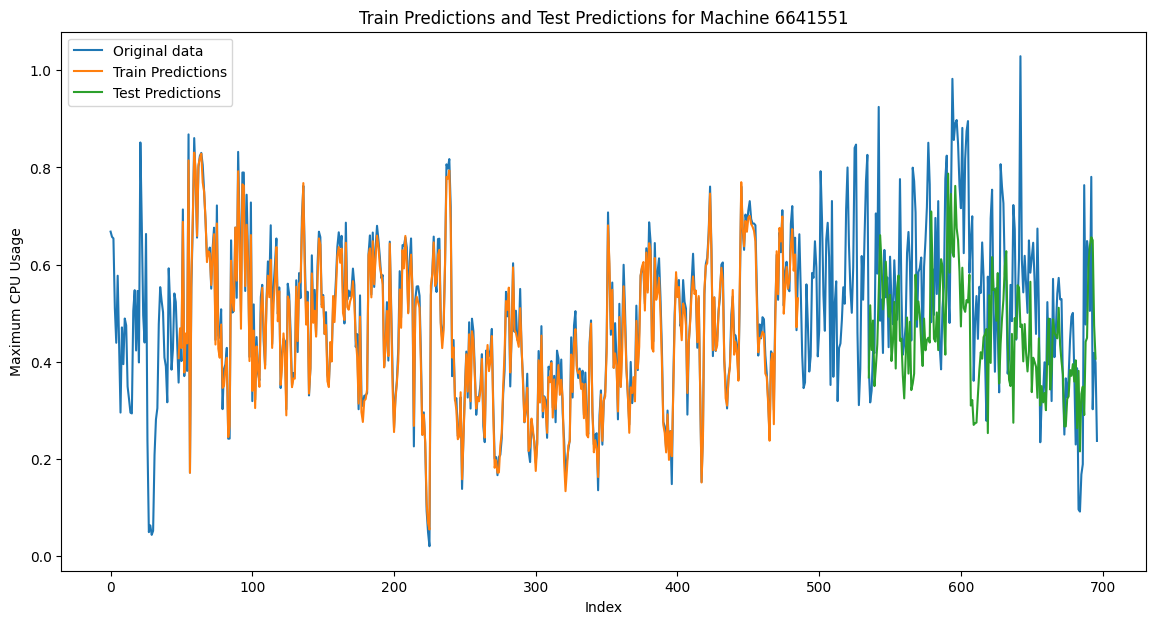

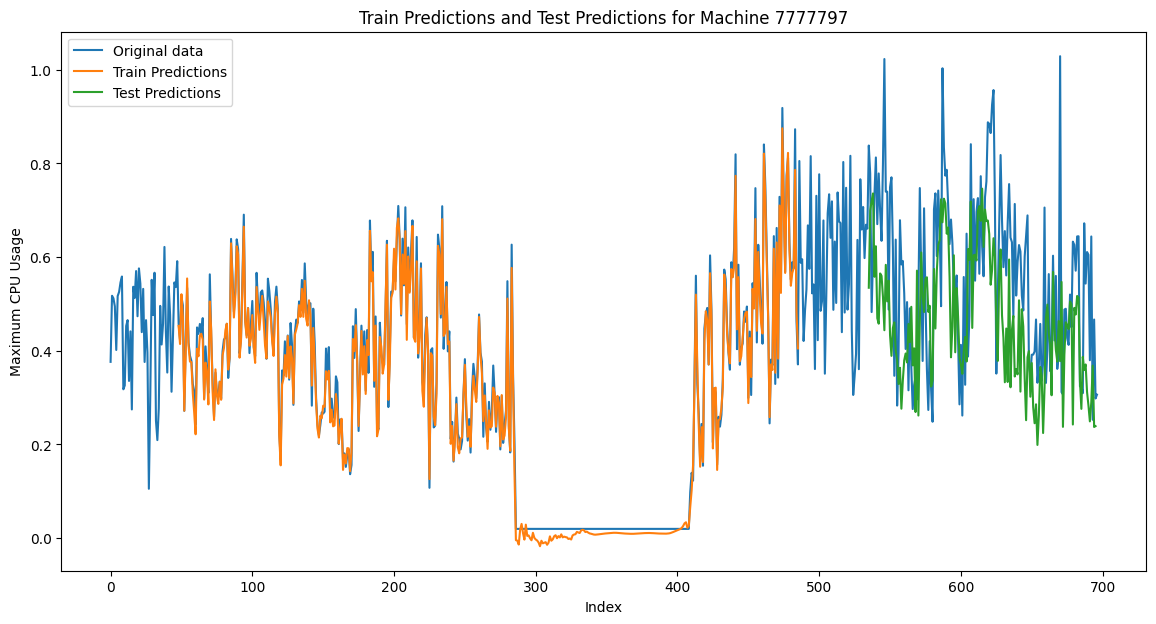

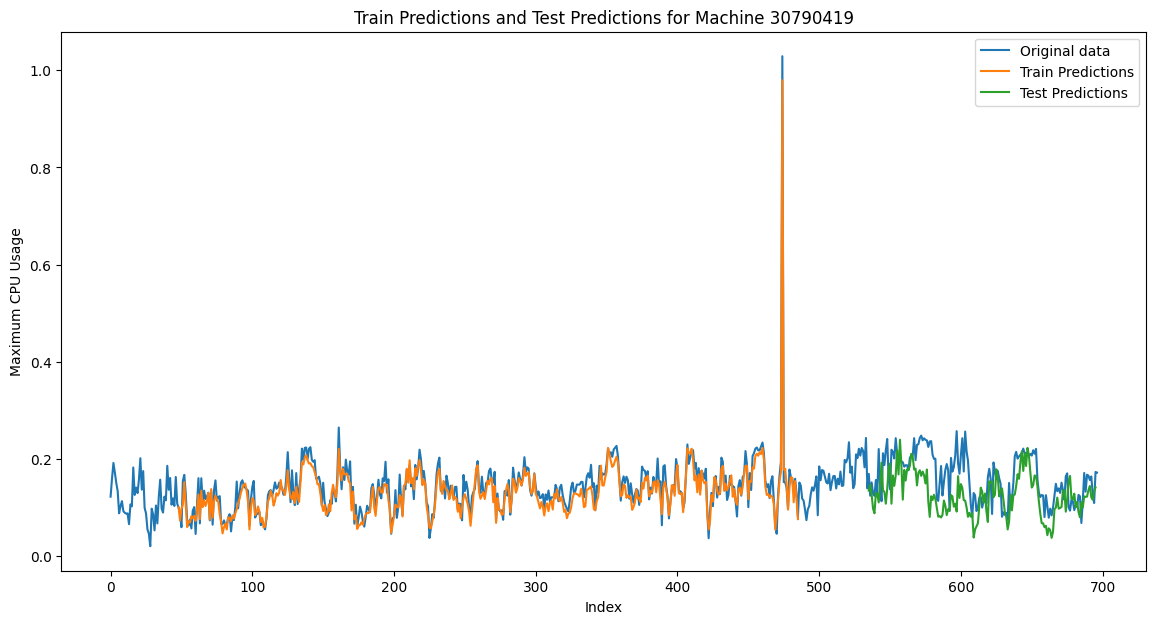

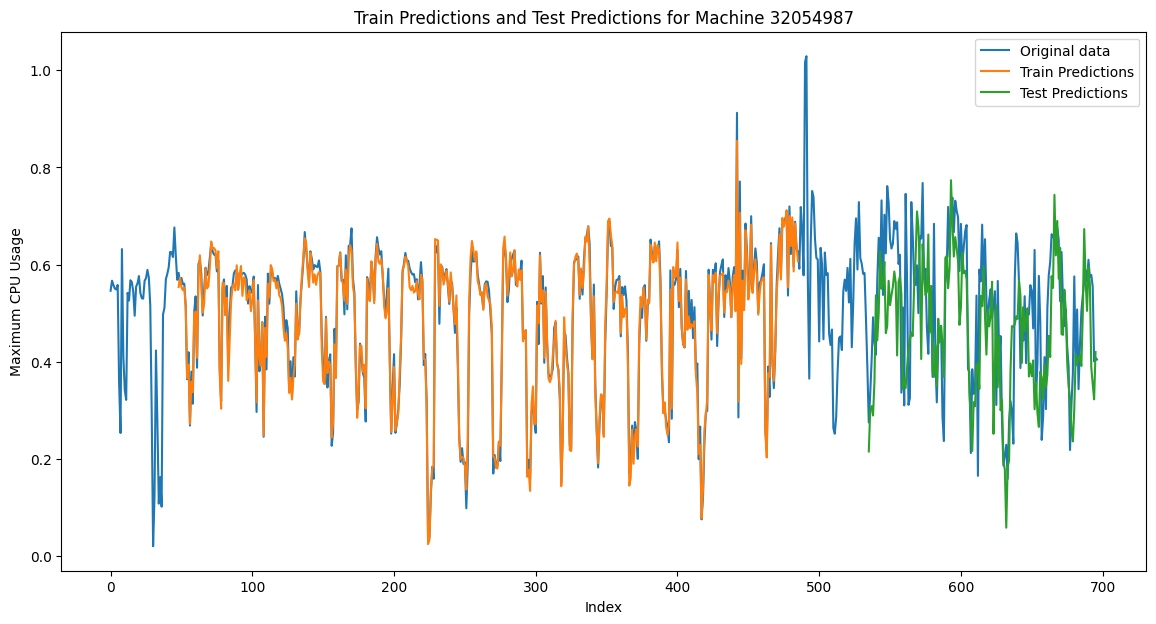

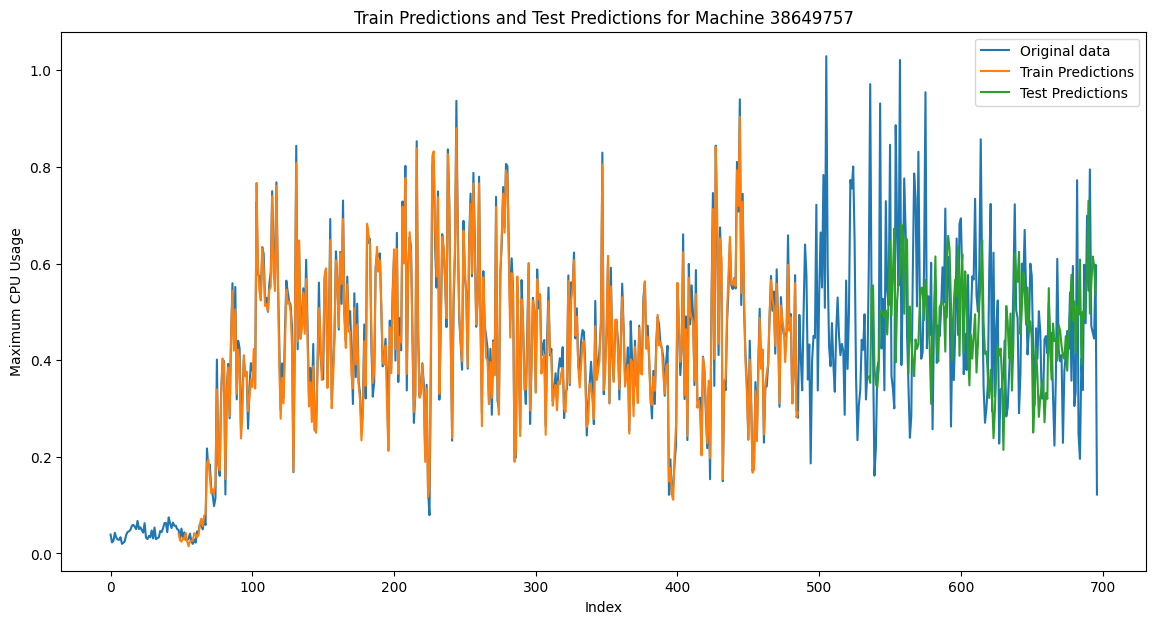

In [5]:
import matplotlib.pyplot as plt   

for machine_id in machines:  
    # Create empty arrays of NaNs  
    train_predictions = np.empty_like(train_data[machine_id])  
    train_predictions[:] = np.nan  
    test_predictions = np.empty_like(test_data[machine_id])  
    test_predictions[:] = np.nan  
  
    # Generate predictions  
    lstm.eval()  
    with torch.no_grad():    
        for i, ((seq_trend, seq_detrended), labels) in enumerate(train_inout_seq[machine_id]):    
            seq_trend = torch.FloatTensor(seq_trend).view(-1, seq_length_in, input_size).to(device)  
            seq_detrended = torch.FloatTensor(seq_detrended).view(-1, seq_length_in, input_size).to(device)  
            labels = torch.FloatTensor(labels).view(-1, seq_length_out).to(device)  
            # print(seq_trend, seq_detrended, labels)
            train_pred = lstm(seq_trend, seq_detrended)
            train_predictions[i+seq_length_in : i+seq_length_in+seq_length_out] = train_pred.cpu().numpy().flatten()    
  
        for i, ((seq_trend, seq_detrended), labels) in enumerate(test_inout_seq[machine_id]):    
            seq_trend = torch.FloatTensor(seq_trend).view(-1, seq_length_in, input_size).to(device)  
            seq_detrended = torch.FloatTensor(seq_detrended).view(-1, seq_length_in, input_size).to(device)  
            labels = torch.FloatTensor(labels).view(-1, seq_length_out).to(device)  
            test_pred = lstm(seq_trend, seq_detrended)   
            test_predictions[i+seq_length_in : i+seq_length_in+seq_length_out] = test_pred.cpu().numpy().flatten()    
  
    train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))    
    test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))    
    data = scaler.inverse_transform(np.concatenate((train_data[machine_id], test_data[machine_id])).reshape(-1, 1))    
  
    # Plotting    
    plt.figure(figsize=(14, 7))    
  
    # Original data    
    plt.plot(range(len(data)), data, label='Original data')    
  
    # Train predictions    
    plt.plot(range(len(train_predictions)), train_predictions, label='Train Predictions')    
  
    # Test predictions    
    plt.plot(range(len(data) - len(test_predictions), len(data)), test_predictions, label='Test Predictions')    
  
    plt.title(f'Train Predictions and Test Predictions for Machine {machine_id}')    
    plt.xlabel('Index')    
    plt.ylabel('Maximum CPU Usage')    
    plt.legend()    
    plt.show()    
